# AI305-Lab3 -Fall 22

## Basic Regression Tree
#### Implementation of a regression tree, step by step



First, we import various
packages and define a function to generate the training and test data.

In [491]:
import numpy as np
from sklearn.datasets import make_friedman1
import numpy as np
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt


make_friedman1()

Generate the “Friedman #1” regression problem.
This dataset is described in Friedman [1] and Breiman [2].
Inputs X are independent features uniformly distributed on the interval [0, 1]. The output y is created according to the formula:
y(X) = 10 * sin(pi * X[:, 0] * X[:, 1]) + 20 * (X[:, 2] - 0.5) ** 2 + 10 * X[:, 3] + 5 * X[:, 4] + noise * N(0, 1).
Out of the n_features features, only 5 are actually used to compute y. The remaining features are independent of y.

In [492]:
def makedata1():
  n_points = 500 # points
 
  X, y =  make_friedman1(n_samples=n_points, n_features=5, 
                         noise=1.0, random_state=100)
         
  return train_test_split(X, y, test_size=0.5, random_state=3)
  

The “main” method calls the makedata method, uses the training data to build a regression tree, and then predicts the responses of the test set and reports the mean squared-error loss.

In [493]:
 
def main():
  X_train, X_test, y_train, y_test = makedata1()    
  maxdepth = 10 # maximum tree depth             
  # Create tree root at depth 0                       
  treeRoot = TNode(0, X_train,y_train) 
       
  # Build the regression tree with maximal depth equal to max_depth
  Construct_Subtree(treeRoot, maxdepth) 
    
  # Predict
  y_hat = np.zeros(len(X_test))
  for i in range(len(X_test)):
     y_hat[i] = Predict(X_test[i],treeRoot)          
    
  MSE = np.mean(np.power(y_hat - y_test,2))    
  print("Basic tree: tree loss = ",  MSE)
  

The next step is to specify a tree node as a Python class. Each node has a number of attributes, including the features and the response data (X and y) and the depth at which the node is placed in the tree. The root node has depth 0. Each node w can calculate its contribution to the squared-error training loss 

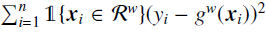


Note that we have omitted the constant 1/n term when training the tree, which simply scales the loss
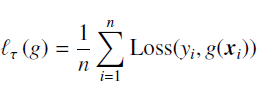

In [494]:
# tree node
class TNode:
   def __init__(self, depth, X, y): 
      self.depth = depth
      self.X = X   # matrix of explanatory variables
      self.y = y   # vector of response variables
      # initialize optimal split parameters
      self.j = None
      self.xi = None
      # initialize children to be None      
      self.left = None
      self.right = None
      # initialize the regional predictor
      self.g = None
      
   def CalculateLoss(self):
       if(len(self.y)==0):
           return 0
       
       return np.sum(np.power(self.y- self.y.mean(),2))
   
   
   
   
   # calculating with the gini impurity
   def CalculateGini(self): # calculate the gini impurity 
        if len(self.y) == 0:# if the node is empty
            return 0# return 0
        classes, counts = np.unique(self.y, return_counts=True)# get the unique classes and their counts
        total = len(self.y)# get the total number of samples
        gini = 1.0 - sum((count / total) ** 2 for count in counts)# calculate the gini impurity
        return gini# return the gini impurity

                    
  

The function below implements the training (tree-building) Algorithm
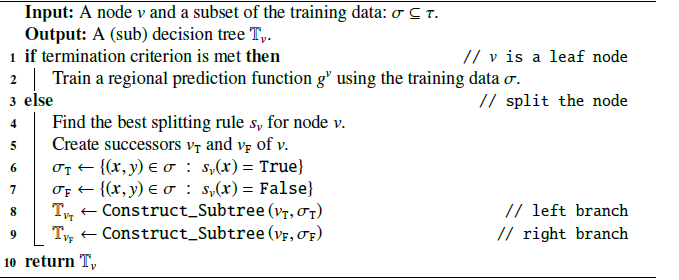

In [495]:
def Construct_Subtree(node, max_depth):  
    if node.depth == max_depth or len(node.y) == 1:
        node.g  = node.y.mean()
        
    else:
        j, xi = CalculateOptimalSplit(node)               
        node.j = j
        node.xi = xi
        Xt, yt, Xf, yf = DataSplit(node.X, node.y, j, xi)
              
        if(len(yt)>0):
            node.left = TNode(node.depth+1,Xt,yt)
            Construct_Subtree(node.left, max_depth)
        
        if(len(yf)>0):        
            node.right = TNode(node.depth+1, Xf,yf)
            Construct_Subtree(node.right, max_depth)      
     
    return node


This requires an implementation of the CalculateOptimalSplit function. To start,
we implement a function DataSplit that splits the data according to 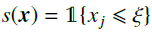

In [496]:
# split the data-set
def DataSplit(X,y,j,xi):
    ids = X[:,j]<=xi      
    Xt  = X[ids == True,:]
    Xf  = X[ids == False,:]
    yt  = y[ids == True]
    yf  = y[ids == False]
    return Xt, yt, Xf, yf 

The CalculateOptimalSplit method runs through the possible splitting thresholds from the set {xj,k} and finds the optimal split.

In [497]:
def CalculateOptimalSplit(node):
    X = node.X
    y = node.y
    best_var = 0
    best_xi = X[0,best_var]          
    best_split_val = node.CalculateLoss()
    
    m, n  = X.shape
    # pass through the predictors and the values
    for j in range(0,n):
        for i in range(0,m):
            xi = X[i,j]
            Xt, yt, Xf, yf = DataSplit(X,y,j,xi)
            tmpt = TNode(0, Xt, yt) 
            tmpf = TNode(0, Xf, yf) 
            loss_t = tmpt.CalculateLoss()
            loss_f = tmpf.CalculateLoss()    
            curr_val =  loss_t + loss_f
            if (curr_val < best_split_val):
                best_split_val = curr_val
                best_var = j
                best_xi = xi
    return best_var,  best_xi

Finally, we implement the recursive method for prediction.

In [498]:
def Predict(X,node):
    if node.right is None and node.left is not None:
        return Predict(X,node.left)
    
    if node.right is not None and node.left is None:
        return Predict(X,node.right)
    
    if node.right is None and node.left is None:
        return node.g
    else:
        if X[node.j] <= node.xi:
            return Predict(X,node.left)
        else:
            return Predict(X,node.right)
 


Running the main function defined above gives a similar result to what one would achieve with the sklearn package, using the DecisionTreeRegressor method.

In [499]:
   
main()  # run the main program

Basic tree: tree loss =  9.067077996170276


In [500]:
# compare with sklearn
from sklearn.tree import DecisionTreeRegressor
X_train, X_test, y_train, y_test = makedata()    
regTree = DecisionTreeRegressor(max_depth = 10, random_state=0)
regTree.fit(X_train,y_train)
y_hat = regTree.predict(X_test)
MSE2 = np.mean(np.power(y_hat - y_test,2))    
print("DecisionTreeRegressor: tree loss = ",  MSE2)      
    

DecisionTreeRegressor: tree loss =  0.852


Plot the DT:

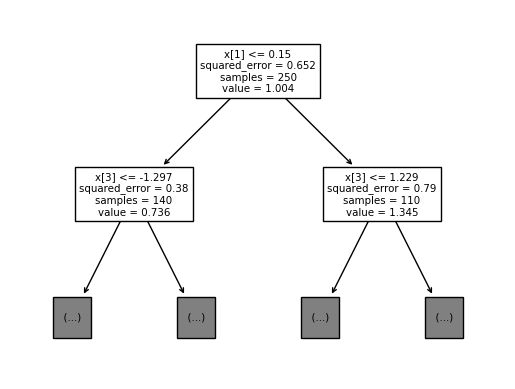

In [501]:
from sklearn import tree
import matplotlib.pyplot as plt
tree.plot_tree(regTree,max_depth=1)
plt.show()

### Activity
#### 1- Modify the previous code to implement classification decision tree
#### 2- implement one of the ensemble methods covered in the lecture: Bagging, random forest, or boosting


###### declaration: use of auto generated comments and code snippets from the following sources:
###### https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
###### https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
###### https://scikit-learn.org/stable/auto_examples/tree/plot_iris_dtc.html
###### https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression.html
###### https://scikit-learn.org/stable/auto_examples/tree/plot_tree_regression_multioutput.html


#### 1- Modify the previous code to implement classification decision tree
the following modifications are needed:
##### 1.Dataset: classification dataset instead of a regression one.
##### 2. Loss Function: I will use Gini impurity for this.
##### 3. prediction: the prediction will be the class that has the majority in the leaf node.


In [502]:
def makedata2():
    n_points = 500  # points
    X, y = make_classification(n_samples=n_points, n_features=5, 
                           n_informative=3, n_redundant=1, n_repeated=0, 
                           n_classes=3, random_state=100)
    return train_test_split(X, y, test_size=0.5, random_state=3)

In [503]:
# same as the regression tree but with Gini impurity
def main2():
    X_train, X_test, y_train, y_test = makedata2()
    maxdepth = 10 
    
    treeRoot = TNode(0, X_train, y_train)
    Construct_Subtree(treeRoot, maxdepth)
    y_hat = np.zeros(len(X_test))
    for i in range(len(X_test)):
        y_hat[i] = Predict(X_test[i], treeRoot)
    
    
    #the new modifications 
    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_hat)
    print("Custom Tree Classifier Accuracy: ", accuracy)

    # Comparing with sklearn's DecisionTreeClassifier
    clf = DecisionTreeClassifier(max_depth=maxdepth, random_state=0)
    clf.fit(X_train, y_train)
    y_hat_sklearn = clf.predict(X_test)
    sklearn_accuracy = accuracy_score(y_test, y_hat_sklearn)
    print("DecisionTreeClassifier Accuracy: ", sklearn_accuracy)

    # Visualize the sklearn tree
    plt.figure(figsize=(12, 8))
    tree.plot_tree(clf, max_depth=1, filled=True)
    plt.show()

Basic tree: tree loss =  9.067077996170276
Custom Tree Classifier Accuracy:  0.72
DecisionTreeClassifier Accuracy:  0.728


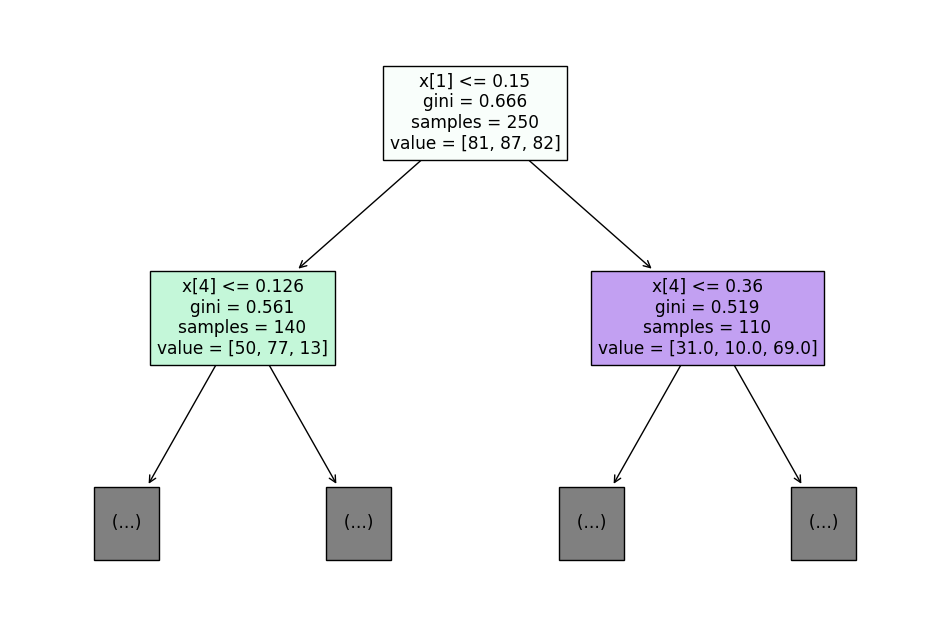

In [504]:
main()
main2()


#### 2- implement one of the ensemble methods covered in the lecture: Bagging, random forest, or boosting

In [505]:

class BaggingClassifier:# Bagging classifier
    def __init__(self, base_estimator, n_estimators=10, max_samples=0.5):# Initialize the Bagging classifier
        self.base_estimator = base_estimator # Base model
        self.n_estimators = n_estimators # Number of models
        self.max_samples = max_samples # Percentage of data to use for each model
        self.models = []  # To store the trained models
        self.sample_indices = []  # To store indices of bootstrap samples
        
    def _bootstrap_sample(self, X, y):# Create a bootstrap sample
        n_samples = int(len(X) * self.max_samples)# Calculate the number of samples
        indices = np.random.choice(len(X), n_samples, replace=True)# Generate random indices
        return X[indices], y[indices] # Return the bootstrap sample
    
    def fit(self, X, y):# Train the Bagging classifier
        for i in range(self.n_estimators):# Train n_estimators models
            X_sample, y_sample = self._bootstrap_sample(X, y)# Create a bootstrap sample
            model = self.base_estimator()# Create a base model
            model.fit(X_sample, y_sample)# Train the base model
            self.models.append(model)  # Save the model
            self.sample_indices.append(np.unique(X_sample, axis=0))  # Save the sample indices
    
    def predict(self, X):# Make predictions by averaging the predictions of the base models
        predictions = np.zeros((len(X), self.n_estimators))# Create an array to store predictions
        for i, model in enumerate(self.models):# Make predictions using each model
            predictions[:, i] = model.predict(X)# Store the predictions
        majority_votes = [np.bincount(pred.astype(int)).argmax() for pred in predictions] # Get the most frequent prediction
        return np.array(majority_votes) # Return the final predictions

In [506]:
def main3():
    # Create dataset and split
    X_train, X_test, y_train, y_test = makedata2()
    
    # Instantiate the Bagging classifier with Decision Tree as the base model
    bagging_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier, n_estimators=10, max_samples=0.5)
    
    # Train the Bagging classifier
    bagging_clf.fit(X_train, y_train)
    
    # Predict and calculate accuracy
    y_pred_bagging = bagging_clf.predict(X_test)
    accuracy_bagging = accuracy_score(y_test, y_pred_bagging)
    print("Bagging Classifier Accuracy: ", accuracy_bagging)

    # Compare with a single Decision Tree Classifier
    clf = DecisionTreeClassifier(max_depth=None, random_state=0)
    clf.fit(X_train, y_train)
    y_pred_tree = clf.predict(X_test)
    accuracy_tree = accuracy_score(y_test, y_pred_tree)
    print("Single Decision Tree Accuracy: ", accuracy_tree)
    

    tree.plot_tree(clf, max_depth=1, filled=True)
    plt.show()

Bagging Classifier Accuracy:  0.772
Single Decision Tree Accuracy:  0.728


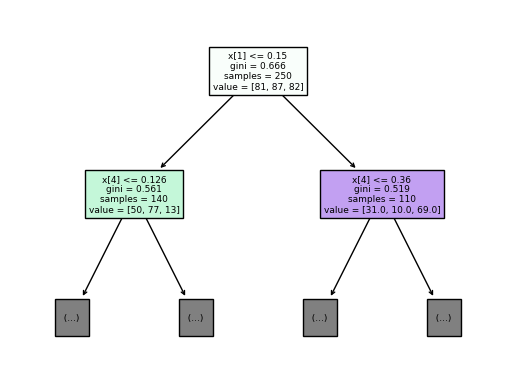

In [507]:
main3()